In [89]:
# Import các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import scipy.sparse
import warnings
warnings.filterwarnings('ignore')

# Thêm các model khác
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import ParameterGrid
# Import thêm RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [56]:
df_train = pd.read_csv('data/train.csv')
df_valid = pd.read_csv('data/valid.csv')
df_test = pd.read_csv('data/test.csv')

Phân tích phân bố nhãn trong các tập dữ liệu:


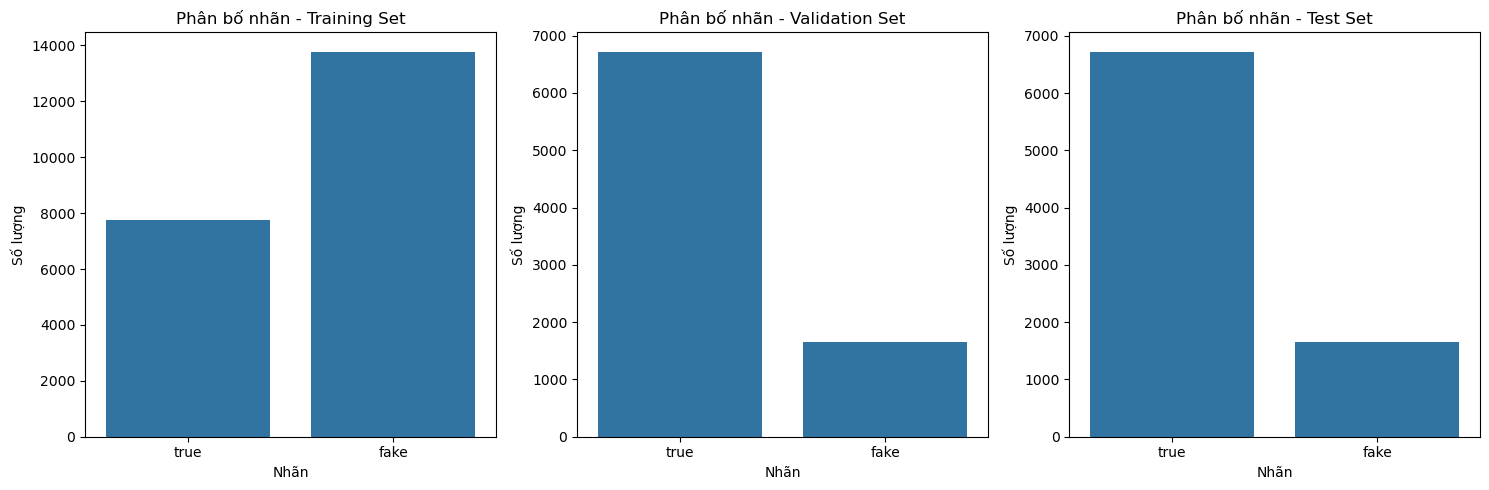


Tỷ lệ phân bố trong các tập:

Training set:
labels
fake    64.0
true    36.0
Name: proportion, dtype: float64

Validation set:
labels
true    80.2
fake    19.8
Name: proportion, dtype: float64

Test set:
labels
true    80.2
fake    19.8
Name: proportion, dtype: float64


In [57]:
# Phân tích phân bố nhãn trong các tập dữ liệu
print("Phân tích phân bố nhãn trong các tập dữ liệu:")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train set
sns.countplot(data=df_train, x='labels', ax=axes[0])
axes[0].set_title('Phân bố nhãn - Training Set')
axes[0].set_xlabel('Nhãn')
axes[0].set_ylabel('Số lượng')

# Valid set
sns.countplot(data=df_valid, x='labels', ax=axes[1])
axes[1].set_title('Phân bố nhãn - Validation Set')
axes[1].set_xlabel('Nhãn')
axes[1].set_ylabel('Số lượng')

# Test set
sns.countplot(data=df_test, x='labels', ax=axes[2])
axes[2].set_title('Phân bố nhãn - Test Set')
axes[2].set_xlabel('Nhãn')
axes[2].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

# In tỷ lệ phần trăm
print("\nTỷ lệ phân bố trong các tập:")
print("\nTraining set:")
print(df_train['labels'].value_counts(normalize=True).round(3) * 100)
print("\nValidation set:")
print(df_valid['labels'].value_counts(normalize=True).round(3) * 100)
print("\nTest set:")
print(df_test['labels'].value_counts(normalize=True).round(3) * 100)

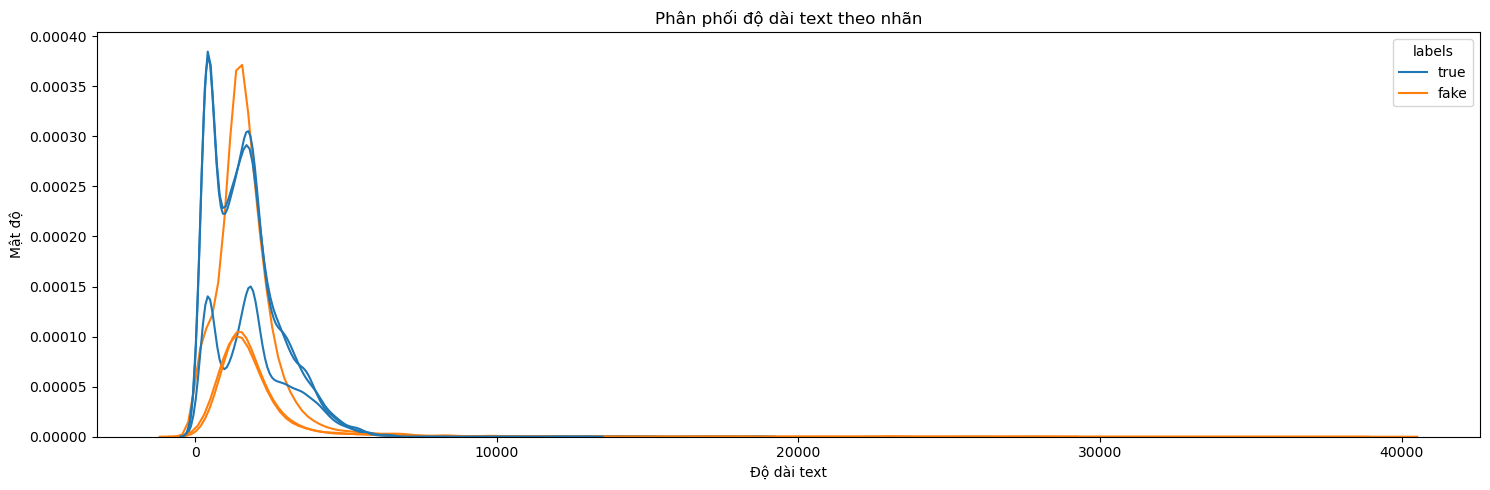

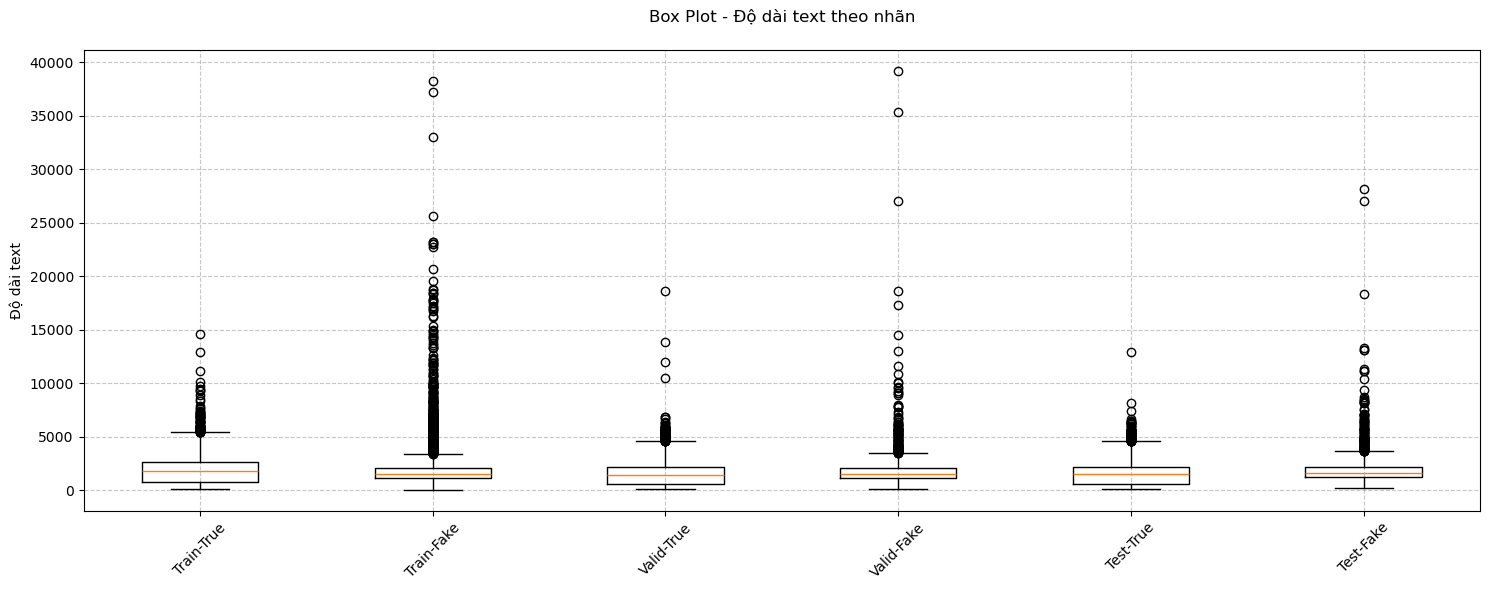

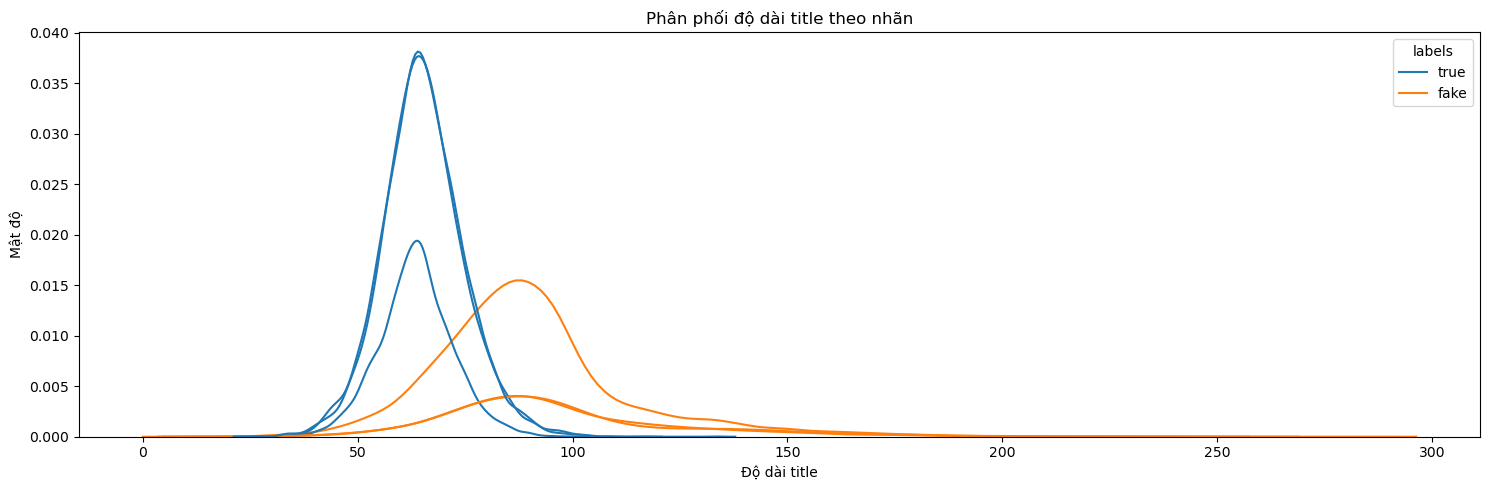

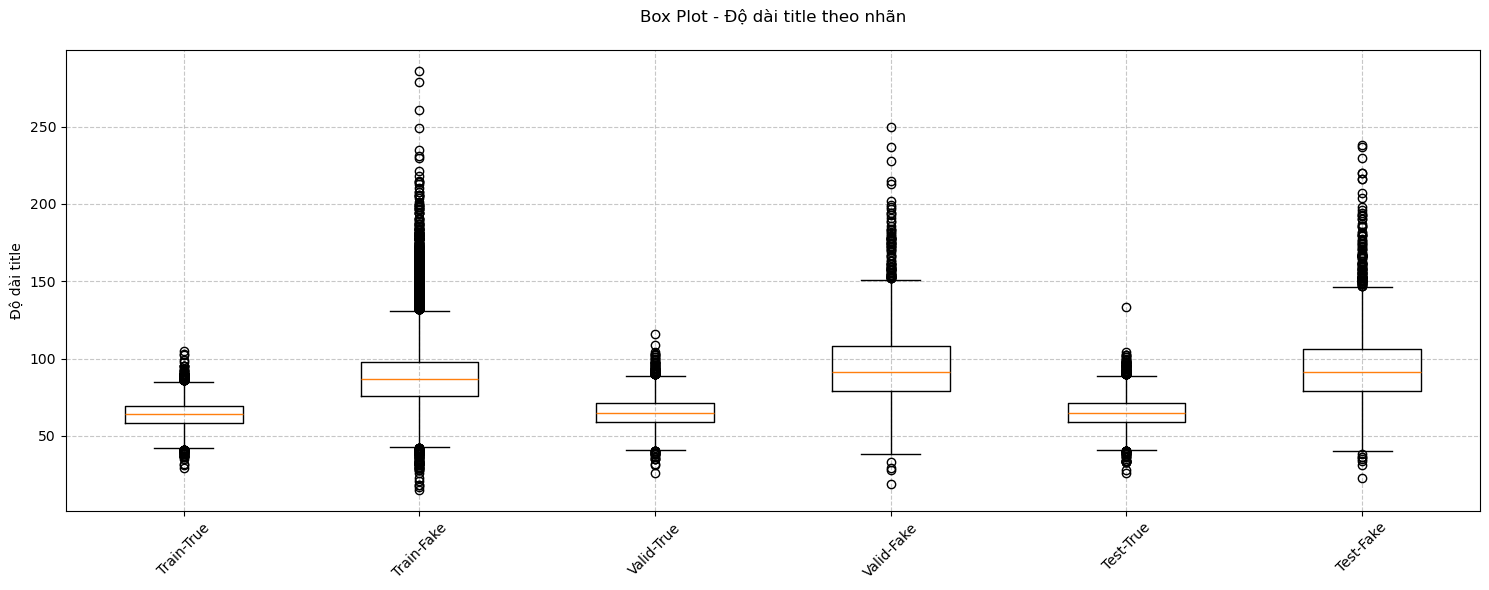

In [74]:
# Phân tích độ dài văn bản
# Tính độ dài cho text và title
for df in [df_train, df_valid, df_test]:
    df['text_length'] = df['text'].str.len()
    df['title_length'] = df['title'].str.len()

# Phân phối độ dài text
plt.figure(figsize=(15, 5))
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    sns.kdeplot(data=df, x='text_length', hue='labels', label=name)
plt.title('Phân phối độ dài text theo nhãn')
plt.xlabel('Độ dài text')
plt.ylabel('Mật độ')
plt.tight_layout()
plt.show()

# Box plot độ dài text
plt.figure(figsize=(15, 6))
data = []
labels = []
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    data.extend([df[df['labels']=='true']['text_length'], df[df['labels']=='fake']['text_length']])
    labels.extend([f'{name}-True', f'{name}-Fake'])
plt.boxplot(data, labels=labels)
plt.title('Box Plot - Độ dài text theo nhãn', pad=20)
plt.xticks(rotation=45)
plt.ylabel('Độ dài text')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Phân phối độ dài title  
plt.figure(figsize=(15, 5))
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    sns.kdeplot(data=df, x='title_length', hue='labels', label=name)
plt.title('Phân phối độ dài title theo nhãn')
plt.xlabel('Độ dài title')
plt.ylabel('Mật độ')
plt.tight_layout()
plt.show()

# Box plot độ dài title
plt.figure(figsize=(15, 6))
data = []
labels = []
for name, df in zip(['Train', 'Valid', 'Test'], [df_train, df_valid, df_test]):
    data.extend([df[df['labels']=='true']['title_length'], df[df['labels']=='fake']['title_length']])
    labels.extend([f'{name}-True', f'{name}-Fake'])
plt.boxplot(data, labels=labels)
plt.title('Box Plot - Độ dài title theo nhãn', pad=20)
plt.xticks(rotation=45)
plt.ylabel('Độ dài title')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [60]:
# Chuẩn bị dữ liệu và vectorization
# Tạo features và labels
X_train = df_train['text']
# Chuyển đổi nhãn từ 'true'/'fake' sang 1/0
y_train = (df_train['labels'] == 'true').astype(int)
X_valid = df_valid['text']
y_valid = (df_valid['labels'] == 'true').astype(int)
X_test = df_test['text']
y_test = (df_test['labels'] == 'true').astype(int)

print("Kiểm tra giá trị nhãn sau khi chuyển đổi:")
print("\nTrain set:", np.unique(y_train))
print("Valid set:", np.unique(y_valid))
print("Test set:", np.unique(y_test))

# Vectorization với TF-IDF
print("\nVectorizing dữ liệu...")
vectorizer = TfidfVectorizer(max_features=5000)
xv_train = vectorizer.fit_transform(X_train)
xv_valid = vectorizer.transform(X_valid)
xv_test = vectorizer.transform(X_test)

# Thêm features độ dài
train_lengths = scipy.sparse.csr_matrix(np.column_stack([
    df_train['text_length'].values,
    df_train['title_length'].values
]))
valid_lengths = scipy.sparse.csr_matrix(np.column_stack([
    df_valid['text_length'].values,
    df_valid['title_length'].values
]))
test_lengths = scipy.sparse.csr_matrix(np.column_stack([
    df_test['text_length'].values,
    df_test['title_length'].values
]))

# Kết hợp features
xv_train_combined = scipy.sparse.hstack([xv_train, train_lengths])
xv_valid_combined = scipy.sparse.hstack([xv_valid, valid_lengths])
xv_test_combined = scipy.sparse.hstack([xv_test, test_lengths])

Kiểm tra giá trị nhãn sau khi chuyển đổi:

Train set: [0 1]
Valid set: [0 1]
Test set: [0 1]

Vectorizing dữ liệu...


In [61]:
# SMOTE để cân bằng dữ liệu
print("Áp dụng SMOTE cho training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(xv_train_combined, y_train)

print("\nPhân bố dữ liệu trước SMOTE:")
print(Counter(y_train))
print("\nPhân bố dữ liệu sau SMOTE:")
print(Counter(y_train_resampled))

Áp dụng SMOTE cho training data...

Phân bố dữ liệu trước SMOTE:
Counter({0: 13781, 1: 7746})

Phân bố dữ liệu sau SMOTE:
Counter({1: 13781, 0: 13781})

Phân bố dữ liệu trước SMOTE:
Counter({0: 13781, 1: 7746})

Phân bố dữ liệu sau SMOTE:
Counter({1: 13781, 0: 13781})


In [75]:
# Hàm đánh giá model
def evaluate_model(model, X_train, y_train, X_valid, y_valid, model_name):
    # Training
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Đánh giá chỉ trên validation set
    y_valid_pred = model.predict(X_valid)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    print(f"\nKết quả {model_name} trên validation set:")
    print(f"Accuracy: {valid_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_valid, y_valid_pred))
    
    # Vẽ confusion matrix cho validation set
    plt.figure(figsize=(6, 5))
    cm_valid = confusion_matrix(y_valid, y_valid_pred)  
    sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}\nValidation Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return valid_acc, model

In [90]:
# Hàm tối ưu hyperparameter bằng Random Search
def optimize_model(model_class, param_dist, X_train, y_train, X_valid, y_valid, model_name, n_iter=10):  # Giảm n_iter xuống 10
    print(f"\nTối ưu hyperparameter cho {model_name} bằng Random Search...")
    
    # Khởi tạo RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model_class(),
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=3,        # Giảm cv xuống 3
        random_state=42,
        n_jobs=-1,   # Sử dụng tất cả CPU cores
        scoring='accuracy',
        verbose=2    # Thêm verbose để theo dõi tiến trình
    )
    
    # Fit trên training data
    random_search.fit(X_train, y_train)
    
    # Đánh giá trên validation set
    valid_score = random_search.score(X_valid, y_valid)
    
    print(f"\nHyperparameter tốt nhất cho {model_name}:")
    print(random_search.best_params_)
    print(f"Validation accuracy: {valid_score:.4f}")
    
    return random_search.best_estimator_, valid_score, random_search.best_params_

# Dictionary chứa các model và phân phối hyperparameter
model_configs = {
    'Logistic Regression': {
        'class': LogisticRegression,
        'params': {
            'C': uniform(0.1, 10.0),        # Thu hẹp khoảng tìm kiếm
            'max_iter': [1000],
            'random_state': [42]
        }
    },
    'Random Forest': {
        'class': RandomForestClassifier,
        'params': {
            'n_estimators': randint(50, 200),   # Thu hẹp khoảng tìm kiếm
            'max_depth': randint(10, 30),       # Thu hẹp khoảng tìm kiếm
            'min_samples_split': randint(2, 10), # Thu hẹp khoảng tìm kiếm
            'min_samples_leaf': randint(1, 5),   # Thu hẹp khoảng tìm kiếm
            'n_jobs': [-1],
            'random_state': [42]
        }
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {
            'n_estimators': randint(50, 200),
            'max_depth': randint(3, 8),
            'learning_rate': uniform(0.05, 0.25),
            'min_child_weight': randint(1, 5),
            'subsample': uniform(0.8, 0.2),
            'colsample_bytree': uniform(0.8, 0.2),
            'n_jobs': [-1],
            'random_state': [42]
        }
    }
}

# Tối ưu và lưu kết quả cho mỗi model
optimized_models = {}
for model_name, config in model_configs.items():
    best_model, best_score, best_params = optimize_model(
        config['class'],
        config['params'],
        X_train_resampled, 
        y_train_resampled,
        xv_valid_combined,
        y_valid,
        model_name
    )
    optimized_models[model_name] = {
        'model': best_model,
        'validation_score': best_score,
        'params': best_params
    }

# So sánh kết quả các model đã tối ưu trên validation set
results_df = pd.DataFrame({
    'Model': list(optimized_models.keys()),
    'Validation Accuracy': [res['validation_score'] for res in optimized_models.values()]
})

print("\nBảng so sánh kết quả các model đã tối ưu trên validation set:")
print(results_df.to_string(index=False))

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.title('So sánh độ chính xác của các model đã tối ưu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chọn model tốt nhất dựa trên validation accuracy
best_model_name = results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Model']
best_model = optimized_models[best_model_name]['model']
print(f"\nModel có hiệu suất tốt nhất trên validation set: {best_model_name}")
print(f"Validation accuracy: {results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Validation Accuracy']:.4f}")
print(f"Hyperparameter tốt nhất: {optimized_models[best_model_name]['params']}")

# Đánh giá model tốt nhất trên test set
print("\nĐánh giá model tốt nhất trên test set:")
y_test_pred = best_model.predict(xv_test_combined)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_acc:.4f}")
print("\nClassification Report trên test set:")
print(classification_report(y_test, y_test_pred))

# Vẽ confusion matrix cho test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}\nTest Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# So sánh validation và test performance
print("\nSo sánh performance giữa validation và test set:")
print(f"Validation accuracy: {results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Validation Accuracy']:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Độ chênh lệch: {abs(results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Validation Accuracy'] - test_acc):.4f}")

# Vẽ ROC curve cho test set
if hasattr(best_model, "predict_proba"):
    y_test_proba = best_model.predict_proba(xv_test_combined)[:, 1]
else:
    y_test_proba = best_model.decision_function(xv_test_combined)
    
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name} trên Test Set')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Tối ưu hyperparameter cho Logistic Regression bằng Random Search...

Hyperparameter tốt nhất cho Logistic Regression:
{'C': 9.50814306409916, 'max_iter': 1000, 'random_state': 42}
Validation accuracy: 0.9628

Tối ưu hyperparameter cho Random Forest bằng Random Search...

Hyperparameter tốt nhất cho Logistic Regression:
{'C': 9.50814306409916, 'max_iter': 1000, 'random_state': 42}
Validation accuracy: 0.9628

Tối ưu hyperparameter cho Random Forest bằng Random Search...


KeyboardInterrupt: 